In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv = 'MonthlyAverageAirPollutionInSeoul.csv'

seoul_map = [ # 9 by 8 matrix, 25 borough
    [0, 0, 0, 0, '도봉구', '노원구', 0, 0],
    [0, 0, 0, '강북구', '강북구', '노원구', '노원구', 0],
    [0, '은평구', '종로구', '성북구', '성북구', '성북구', '중랑구', 0],
    [0, '은평구', '서대문구', '종로구', '종로구', '동대문구', '중랑구', 0],
    [0, '은평구', '서대문구', '서대문구', '중구', '성동구', '광진구', '강동구'],
    [0, '마포구', '마포구', '마포구', '용산구', '강남구', '송파구', '강동구'],
    ['강서구', '강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', 0],
    [0, '양천구', '영등포구', '관악구', '서초구', '강남구', '송파구', 0],
    [0, '구로구', '금천구', '관악구', '서초구', 0, 0, 0]
]

with open(csv) as f:
    raw_data = f.read().strip()

In [3]:
del_quote = raw_data.replace("\"", '')
data = list(map(lambda x: x.split(','), del_quote.split('\n')))[1:]

splitted = []

ptr = 0
for i in range(len(data) // 39):
    splitted.append(data[ptr:ptr+39])
    ptr += 39
    
## test case
for date_list in splitted:
    date = date_list[0][0]
    for local in date_list:
        if date != local[0]:
            raise ValueError(date + ' is not same as ' + 'local[0]')

In [4]:
def filter_borough(dic):
    return dict(filter(lambda t: '구' in t[0], dic.items()))

pms = dict(map(lambda x: (x[0][0], dict(map(lambda x: (x[1], x[6]), x))), splitted))
pms_filtered = dict(filter(lambda x: '' not in x[1].values(), pms.items()))
pms_filtered2 = dict(map(lambda x: (x[0], filter_borough(x[1])), pms_filtered.items()))

In [5]:
def dict2seoul(p):
    return list(map(lambda t: list(map(lambda x: int(p[x]) if x != 0 else 0, t)), seoul_map))

pms_mapped = dict(map(lambda p: (p[0], dict2seoul(p[1])), pms_filtered2.items()))
pms_data = list(map(lambda x: x[1], sorted(pms_mapped.items())))

pms_sampled = list(map(lambda i: pms_data[i:i+7], range(281 - 7)))
pms_result = list(map(lambda x: list(map(lambda t: t[1], sorted(x[1].items()))), sorted(pms_filtered2.items())))[7:]

In [6]:
data_set = list(zip(pms_sampled, pms_result))
np.random.shuffle(data_set)

train_set, test_set = data_set[:250], data_set[250:]

train_sampled = list(map(lambda x: x[0], train_set))
train_result = list(map(lambda x: x[1], train_set))

In [7]:
X = tf.placeholder(tf.float32, [None, 7, 9, 8])
Y = tf.placeholder(tf.float32, [None, 25])

X_transpose = tf.transpose(X, [0, 2, 3, 1])

In [8]:
w1 = tf.get_variable('w1', shape=[3, 3, 7, 4],
                    initializer=tf.random_normal_initializer(stddev=0.02))
w2 = tf.get_variable('w2', shape=[3, 3, 4, 2],
                    initializer=tf.random_normal_initializer(stddev=0.02))
w3 = tf.get_variable('w3', shape=[3, 3, 2, 1],
                    initializer=tf.random_normal_initializer(stddev=0.02))

l1 = tf.nn.conv2d(X_transpose, w1, strides=[1, 1, 1, 1], padding='SAME')
l1 = tf.nn.relu(tf.contrib.layers.batch_norm(l1))

l2 = tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME')
l2 = tf.nn.relu(tf.contrib.layers.batch_norm(l2))

l3 = tf.nn.conv2d(l2, w3, strides=[1, 1, 1, 1], padding='SAME')
l3 = tf.nn.relu(tf.contrib.layers.batch_norm(l3))

l3_reshaped = tf.reshape(l3, [-1, 9 * 8, 1])

In [9]:
gru_cell = tf.contrib.rnn.LSTMCell(8)
out, state = tf.nn.dynamic_rnn(gru_cell, l3_reshaped, dtype=tf.float32)

l4 = tf.transpose(out, [1, 0, 2])[-1]

In [10]:
w4 = tf.get_variable('w4', shape=[8, 25],
                    initializer=tf.random_normal_initializer(stddev=0.02))

l5 = tf.contrib.layers.batch_norm(tf.matmul(l4, w4))
pred = tf.nn.relu(l5)

loss = tf.reduce_mean(tf.square(Y - pred))
opt = tf.train.AdamOptimizer(0.01).minimize(loss)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
d_loss = []

for i in range(1000):  
    _, new_loss = sess.run([opt, loss], feed_dict={X: train_sampled, Y: train_result})

    d_loss.append(new_loss)
    
    if i % 100 == 0:
        print(i, new_loss)

0 2729.37
100 2679.33
200 2674.13
300 2669.13
400 2664.29
500 2659.63
600 2654.41
700 2649.83
800 2624.35
900 2611.14


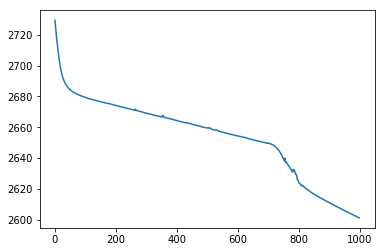

In [13]:
plt.plot(d_loss)

In [14]:
sess.close()